## Importación de módulos

In [1]:
import pandas_ta as ta
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
import MetaTrader5 as mt5
import warnings
warnings.filterwarnings("ignore")

## Funciones auxiliares

In [17]:
%run backtest_functions.ipynb

In [3]:
def fetch_bitstamp_data(symbol, start, end, timeframe, limit=1000):
    url = f"https://www.bitstamp.net/api/v2/ohlc/{symbol}/"
    data_frames = []
    while start < end:
        # Ajustar end para la solicitud actual para no exceder el límite de 1000 registros
        current_end = start + (timeframe * limit)
        # Debug
        #print(f"{pd.to_datetime(start, unit='s')} - {pd.to_datetime(current_end, unit='s')}")
        params = {
            'start': int(start),
            'end': int(current_end),
            'step': timeframe,
            'limit': limit,
            'exclude_current_candle': False
        }
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                df = pd.DataFrame(data['data']['ohlc'])
                if not df.empty:
                    data_frames.append(df)
            else:
                raise Exception(f"Failed to fetch data: {response.status_code}, {response.text}")
        except Exception as e:
            print(e)
            break
        start = current_end
    # Combinar todos los DataFrames
    if data_frames:
        df = pd.concat(data_frames, ignore_index=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.set_index('timestamp')
        df = df.sort_index()
        df.index.name = 'date'
        df = df.astype({
            'open': float,
            'high': float,
            'low': float,
            'close': float,
            'volume': float
        })
        return df
    else:
        return pd.DataFrame()

In [4]:
def find_timestamp_extremum(df_highest, df_lowest):
    """
    params:
        df_highest_timeframe(highest timeframe OHLCV dataframe)
        df_lowest_timeframe(lowest timeframe OHLCV dataframe)
    """
    # Añadir nuevas columnas si no existen
    for col in ['Low_time', 'High_time', 'First']:
        if col not in df_highest.columns:
            df_highest[col] = np.nan
    # Establecer qué sucedió antes si High o Low
    index_starts = df_highest.index[:-1]
    index_ends = df_highest.index[1:]
    for start, end in zip(index_starts, index_ends):
        row_lowest_timeframe = df_lowest.loc[start:end]
        if len(row_lowest_timeframe) > 1:
            row_lowest_timeframe = row_lowest_timeframe.iloc[:-1]
        try:
            high = row_lowest_timeframe['high'].idxmax()
            low = row_lowest_timeframe['low'].idxmin()
            df_highest.loc[start, 'High_time'] = high
            df_highest.loc[start, 'Low_time'] = low
        except Exception as e:
            print(f'Exception occurred: {e}')
            df_highest.loc[start, 'High_time'] = start
            df_highest.loc[start, 'Low_time'] = start
    # Asegurar que las columnas son de tipo datetime
    df_highest['High_time'] = pd.to_datetime(df_highest['High_time'])
    df_highest['Low_time'] = pd.to_datetime(df_highest['Low_time'])
    # Find out which appears first
    df_highest.loc[df_highest['High_time'] > df_highest['Low_time'], 'First'] = 1
    df_highest.loc[df_highest['High_time'] < df_highest['Low_time'], 'First'] = 2
    df_highest.loc[df_highest['High_time'] == df_highest['Low_time'], 'First'] = 0
    # Verificar el número de filas sin TP ni SL al mismo tiempo
    percentage_garbage_row = len(df_highest.loc[df_highest['First']==0].dropna()) / len(df_highest) * 100.
    print(f'WARNING: Filas no válidas para establecer TP/SL: {percentage_garbage_row:.2f} %')
    # Remover la última columna porque no es posible encontrar el extremo
    df_highest = df_highest.iloc[:-1]
    return df_highest

In [5]:
def run_tp_sl(df, leverage=1, tp=0.015, sl=-0.015, cost=0.00):
    '''
    params (mandatory): 
        df - DataFrame with High_time and Low_time columns
    params (optional):
        leverage=1, tp_0.015, ls=-0.015, cost=0.00
    return:
        df - Incoming DataFrame with two new columns ['returns', 'duration']
    '''
    # Establecer valores iniciales
    buy = False
    sell = False
    df['duration'] = 0
    # Bucle principal
    for i in range(len(df)):
        # Extraer fila
        row = df.iloc[i]
        # ABRIR COMPRA
        if buy == False and row['signal'] == 1:
            buy = True
            open_buy_price = row['open']
            open_buy_date = row.name
        if buy:
            # Verificar variación
            var_buy_high = (row['high'] - open_buy_price) / open_buy_price
            var_buy_low = (row['low'] - open_buy_price) / open_buy_price
            # Comprobar localización de TP y SL
            if (var_buy_high > tp) and (var_buy_low < sl):
                # Si ambos tienen el mismo timestamp, no se considera el trade
                if row["First"] == 0:
                    pass
                elif row['First'] == 2:
                    df.loc[row.name, 'returns'] = (tp - cost) * leverage
                    df.loc[row.name, 'duration'] = row['High_time'] - open_buy_date
                elif row['First'] == 1:
                    df.loc[row.name, 'returns'] = (sl - cost) * leverage
                    df.loc[row.name, 'duration'] = row['Low_time'] - open_buy_date
                # Resetear valores
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None
            elif var_buy_high > tp:
                df.loc[row.name, 'returns'] = (tp - cost) * leverage
                df.loc[row.name, 'duration'] = row['High_time'] - open_buy_date
                # Resetear valores
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None
            elif var_buy_low < sl:
                df.loc[row.name, 'returns'] = (sl - cost) * leverage
                df.loc[row.name, 'duration'] = row['Low_time'] - open_buy_date
                # Resetear valores
                buy = False
                open_buy_price = None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None
        # ABRIR VENTA
        if sell == False and row['signal'] == -1:
            sell = True
            open_sell_price = row['open']
            open_sell_date = row.name
        if sell:
            # Verificar variación
            var_sell_high = -(row['high'] - open_sell_price) / open_sell_price
            var_sell_low = -(row['low'] - open_sell_price) / open_sell_price
            # Comprobar localización de TP y SL
            if (var_sell_low > tp) and (var_sell_high < sl):
                # Si ambos tienen el mismo timestamp, no se considera el trade
                if row['First'] == 0:
                    pass
                elif row['First'] == 1:
                    df.loc[row.name, 'returns'] = (tp - cost) * leverage
                    df.loc[row.name, 'duration'] = row['Low_time'] - open_sell_date
                elif row['First'] == 2:
                    df.loc[row.name, 'returns'] = (sl - cost) * leverage
                    df.loc[row.name, 'duration'] = row['High_time'] - open_sell_date
                # Resetear valores
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None
            elif var_sell_low > tp:
                df.loc[row.name, 'returns'] = (tp - cost) * leverage
                df.loc[row.name, 'duration'] = row['Low_time'] - open_sell_date
                # Resetear valores
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None
            elif var_sell_high < sl:
                df.loc[row.name, 'returns'] = (sl - cost) * leverage
                df.loc[row.name, 'duration'] = row['High_time'] - open_sell_date
                # Resetear valores
                sell = False
                open_sell_price = None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None
    # Eliminar columnas inncesarias
    df = df.drop(labels=['Low_time', 'High_time'], axis=1)
    # Rellenar con 0s valores faltantes
    df['returns'] = df['returns'].fillna(value=0)
    # retornar df
    return df

## Descarga de datos

In [6]:
# Descarga de históricos OHLCV
start_date = pd.Timestamp('2014-01-01').timestamp()
end_date = pd.Timestamp.now(tz='UTC').timestamp()
df = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=3600)
df_lowest_timeframe = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=60)
# Comprobar filas duplicadas
if df.index.duplicated().any():
    df.groupby(df.index).filter(lambda x: len(x) > 1)

In [7]:
# Descarga de precios del índice de referencia (SP500)
if mt5.initialize():
    # Obtener índice de referencia
    data_index = mt5.copy_rates_range('SP500', mt5.TIMEFRAME_D1, df.index[0], df.index[-1])
    df_index = pd.DataFrame(data_index['close'], index=data_index['time'], columns=['index'])
    df_index = np.log(df_index).diff().dropna()
    df_index.index.names = ['date']
    df_index.index = pd.to_datetime(df_index.index, unit='s')
    df_index = df_index.loc[df.index[0]:df.index[-1]]

## Ingeniería de características

In [10]:
# Sistema Alpha (por Jose Antonio Fernández Martín)
def alpha_system(df):
    #ichimoku solo las líneas superior e inferior de la nube. Params (7, 22, 44) ó (120, 26, 52)
    ichimoku = df.ta.ichimoku(high='high', low='low', close='close', tenkan=7, kijun=22, senkou=44)
    stochastic = df.ta.stoch(high='high', low='low', close='close', k=78, d=78, mamode='ema', offset=1)
    vortex = df.ta.vortex(high='high', low='low', close='close', length=24)
    df['ichimoku_a'] = ichimoku[0]['ISA_7']
    df['ichimoku_b'] = ichimoku[0]['ISB_22']
    df['stoch_k'] = stochastic['STOCHk_78_78_3']
    df['stoch_d'] = stochastic['STOCHd_78_78_3']
    df['vortex_pos'] = vortex['VTXP_24']
    df['vortex_neg'] = vortex['VTXM_24']
    # Eliminar filas con NaN
    df = df.dropna(axis=0)
    # Condición de compra
    df['vortex_buy_signal'] = (df['vortex_pos'] > df['vortex_neg'])
    df['stoch_buy_signal'] = (df['stoch_k'] > df['stoch_d'])
    df['ichimoku_buy_signal'] = (df['close'] > df['ichimoku_a']) & (df['close'] > df['ichimoku_b'])
    # Condición de venta
    df['vortex_sell_signal'] = (df['vortex_pos'] < df['vortex_neg'])
    df['stoch_sell_signal'] = (df['stoch_k'] < df['stoch_d'])
    df['ichimoku_sell_signal'] = (df['close'] < df['ichimoku_a']) & (df['close'] < df['ichimoku_b'])
    # Establecer señal
    df['buy_signal'] = df[['vortex_buy_signal', 'stoch_buy_signal', 'ichimoku_buy_signal']].all(axis=1)
    df['sell_signal'] = df[['vortex_sell_signal', 'stoch_sell_signal', 'ichimoku_sell_signal']].all(axis=1)
    # Asignar 1 donde las condiciones de compra se cumplen por primera vez
    df['signal'] = np.where(df['buy_signal'], 1, 0)
    # Asignar -1 donde las condiciones de venta se cumplen por primera vez
    df['signal'] = np.where(df['sell_signal'], -1, df['signal'])
    # Eliminar señales repetidas manteniendo la primera ocurrencia de cada señal
    df['signal'] = df['signal'].replace(0, np.nan)
    changes = df['signal'].diff().ne(0)
    df['signal'] = df['signal'].where(changes).fillna(0).astype('int64')
    # Eliminar columnas innecesarias
    df = df.drop(labels=['vortex_buy_signal', 'stoch_buy_signal', 'ichimoku_buy_signal', 
                    'vortex_sell_signal', 'stoch_sell_signal', 'ichimoku_sell_signal', 'buy_signal', 'sell_signal'], axis=1)
    # return dataframe
    return df

In [11]:
# Agregar sistema al dataframe
df = alpha_system(df)

## Análisis exploratorio

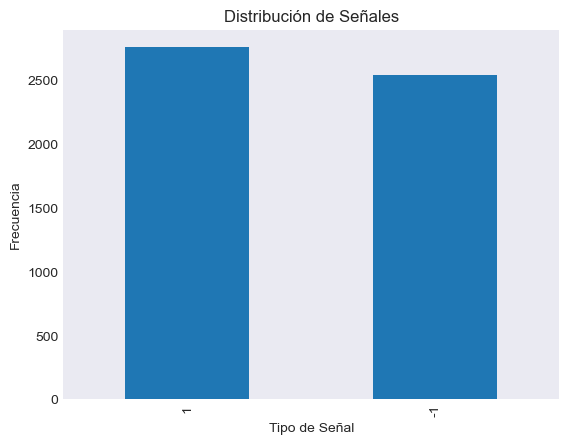

In [12]:
# Visualizar distribución de señales de trading
df['signal'][(df['signal']==1) | (df['signal']==-1)].value_counts().plot(kind='bar')
plt.title('Distribución de Señales')
plt.xlabel('Tipo de Señal')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
# Cálculo de los rendimientos
df = find_timestamp_extremum(df, df_lowest_timeframe)
stdev = df['close'].pct_change().std()
df = run_tp_sl(df, tp=stdev*3.0, sl=-stdev*1.5)

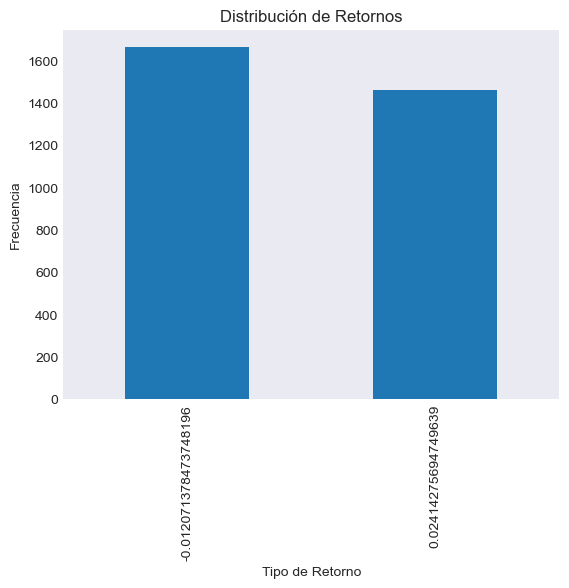

In [14]:
# Visualizar distribución de rendimientos
df['returns'][df['returns']!=0].value_counts().plot(kind='bar')
plt.title('Distribución de Retornos')
plt.xlabel('Tipo de Retorno')
plt.ylabel('Frecuencia')
plt.show()

In [15]:
# ratio SL/TP
num_failed_trades= df['returns'][df['returns']!=0].value_counts().iloc[0]
num_succeed_trades= df['returns'][df['returns']!=0].value_counts().iloc[1]
num_failed_trades/num_succeed_trades

1.139041095890411

## Evaluación


    __________________________________________________
    Portfolio: 
	BTC: 100.00%
    __________________________________________________
    Beta: -0.006
    Alpha: 0.042
    Sharpe: 0.759
    Sortino: 501229847256124.8
    ___________________________________________________
    VaR: -4.865
    cVaR: -7.603
    ___________________________________________________
    


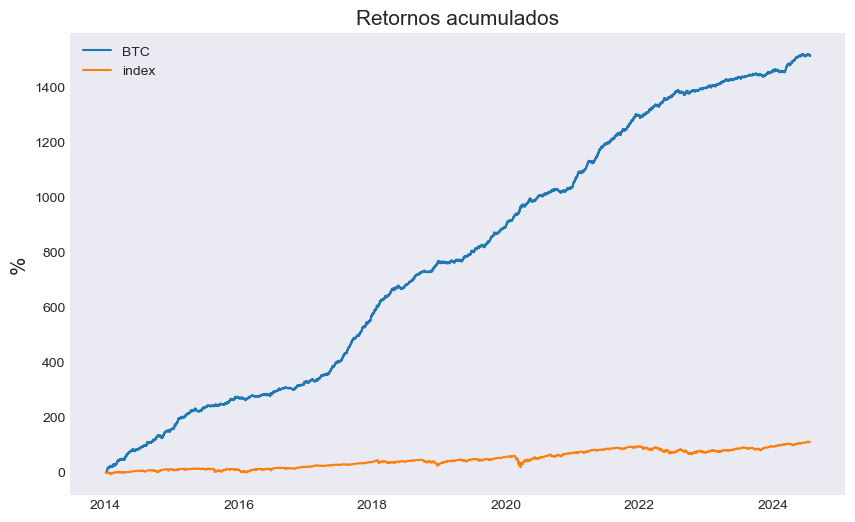

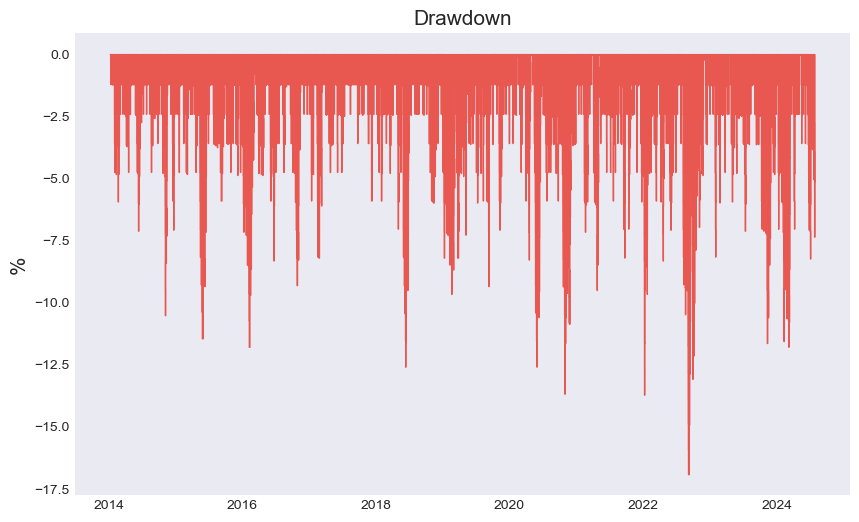

In [18]:
# Backtest de la estrategia
weights = pd.DataFrame([1.], columns=['Weights'], index=['BTC'])
portfolio = df[['returns']].rename(mapper={'returns': 'BTC'}, axis=1)
portfolio.index.names = ['time']
backtest_function(weights=weights, portfolio=portfolio, benchmark=df_index, timeframe=365)